Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# EMNIST TF Lite implementation

This is the notebook based on step 7 of the codelab [**Build a handwritten digit classifier app with TensorFlow Lite**](https://codelabs.developers.google.com/codelabs/digit-classifier-tflite/).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/lite/codelabs/digit_classifier/ml/step7_improve_accuracy.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/lite/codelabs/digit_classifier/ml/step7_improve_accuracy.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

In previous steps, we trained a model that could recognize handwritten digits using the MNIST dataset. We were able to achieve above 98% accuracy on our validation dataset. However, when you deploy the model in an Android app and test it, you probably noticed some accuracy issue. Although the app was able to recognize digits that you drew, the accuracy is probably way lower than 98%.

In this notebook, we will explore the cause of the accuracy drop and use data augmentation to improve deployment accuracy.

## Preparation

Let's start by importing TensorFlow and other supporting libraries that are used for data processing and visualization.

In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

print(tf.__version__)

2.8.2


We are using the EMNIST Bymerge dataset. 
The Bymerge has varying numbers of training data per letter/number. Also, it combines the labelling for capital and lowercase letters for a handful of characters, because training to accurately make distinctions for all 52 capital uppercase and lowercase letters was difficult. 

From 62 total possible letters and digits, we are predicting 47 possible outcomes. 

This dataset and CNN method should create about a 90% accuracty rating. 

In [ ]:
# Gather EMNIST dataset
(train_ds, validation_ds) = tfds.load(
    "emnist/bymerge",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True
)

builder = tfds.builder('emnist/bymerge')
builder.info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/emnist/bymerge/3.0.0.incompleteOPRI3W/emnist-train.tfrecord


  0%|          | 0/697932 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/emnist/bymerge/3.0.0.incompleteOPRI3W/emnist-test.tfrecord


  0%|          | 0/116323 [00:00<?, ? examples/s]

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/bymerge/3.0.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='emnist',
    version=3.0.0,
    description='The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.

Note: Like the original EMNIST data, images provided here are inverted horizontally and rotated 90 anti-clockwise. You can use `tf.transpose` within `ds.map` to convert the images to a human-friendlier format.',
    homepage='https://www.nist.gov/itl/products-and-services/emnist-dataset',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=47),
    }),
    total_num_examples=814255,
    splits={
        'test': 116323,
        'train': 697932,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{cohen_afshar_tapson_schaik_2017,
        title={EMNIST: Extending MNIST to handwritten lett

In [ ]:
def dataset_to_numpy(ds):
    """
    Convert tensorflow dataset to numpy arrays
    """
    images = []
    labels = []

    # Iterate over a dataset
    for i, (image, label) in enumerate(tfds.as_numpy(ds)):
        images.append(image)
        labels.append(label)

    for i, img in enumerate(images):
        if i < 3:
            print(img.shape, labels[i])

    return images, labels

In [ ]:
# Convert Train data to list... idk why it doesn't go stright to numpy
EMNIST_train_data, EMNIST_train_labels = dataset_to_numpy(train_ds)

(28, 28, 1) 5
(28, 28, 1) 10
(28, 28, 1) 46


In [ ]:
# Rotate and Flip all train images
for i in range(np.shape(EMNIST_train_data)[0]):
  EMNIST_train_data[i] = np.transpose(EMNIST_train_data[i], (1, 0, 2))

In [ ]:
# Convert Test data to list... idk why it doesn't go stright to numpy
EMNIST_test_data, EMNIST_test_labels = dataset_to_numpy(validation_ds)

(28, 28, 1) 28
(28, 28, 1) 6
(28, 28, 1) 1


In [ ]:
# Rotate and Flip all train images
for i in range(np.shape(EMNIST_test_data)[0]):
  EMNIST_test_data[i] = np.transpose(EMNIST_test_data[i], (1, 0, 2))

In [ ]:
# Convert data from list to numpy
EMNIST_train_data = np.array(EMNIST_train_data)
EMNIST_test_data = np.array(EMNIST_test_data)

# Normalize the input image so that each pixel value is between 0 to 1.
EMNIST_train_data = EMNIST_train_data / 255.0
EMNIST_test_data = EMNIST_test_data / 255.0

# Add a color dimension to the images in "train" and "validate" dataset to
# leverage Keras's data augmentation utilities later.
EMNIST_train_data = np.expand_dims(EMNIST_train_data, axis=3)
EMNIST_test_data = np.expand_dims(EMNIST_test_data, axis=3)

In [ ]:
EMNIST_train_data = np.reshape(EMNIST_train_data, (593242, 28, 28, 1))
EMNIST_test_data = np.reshape(EMNIST_test_data, (104690, 28, 28, 1))

In [ ]:
# Convert data from list to numpy
EMNIST_train_labels = np.array(EMNIST_train_labels)
EMNIST_test_labels = np.array(EMNIST_test_labels)

In [ ]:
print(np.shape(EMNIST_train_data))
print(np.shape(EMNIST_train_labels))
print(np.shape(EMNIST_test_data))

(593242, 28, 28, 1)
(593242,)
(104690, 28, 28, 1)


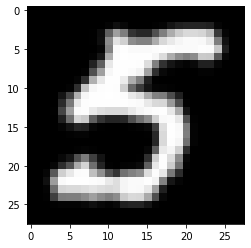

In [ ]:
plt.imshow(np.squeeze(EMNIST_train_data[0], axis=2), cmap=plt.cm.gray)

In [ ]:
print(type(EMNIST_test_labels))
print(type(train_labels))

<class 'list'>
<class 'numpy.ndarray'>


In [ ]:
# train_ds = tf.transpose(train_ds, [1,0,2])
LABELS = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
          'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
          'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']
len(LABELS)

47

Import MNIST dataset.

In [ ]:
### From prior example notebook
# mnist = keras.datasets.mnist
# (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# # Normalize the input image so that each pixel value is between 0 to 1.
# train_images = train_images / 255.0
# test_images = test_images / 255.0

# # Add a color dimension to the images in "train" and "validate" dataset to
# # leverage Keras's data augmentation utilities later.
# train_images = np.expand_dims(train_images, axis=3)
# test_images = np.expand_dims(test_images, axis=3)

11501568/11490434 [==============================] - 0s 0us/step


Define an utility function so that we can create quickly create multiple models with the same model architecture for comparison.

In [ ]:
# We want the last set of nodes to be equal to 47, the number of possible outcomes for this EMNIST set
def create_model():
  model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(28, 28, 1)),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(47, activation=tf.nn.softmax)
  ])
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

Confirm that our model can achieve above 98% accuracy on MNIST dataset.

In [ ]:
### From prior example notebook
# base_model = create_model()
# base_model.fit(
#     train_images,
#     train_labels,
#     epochs=5,
#     validation_data=(test_images, test_labels)
# )

Epoch 1/5
1875/1875 [==============================] - 18s 4ms/step - loss: 0.1372 - accuracy: 0.9585 - val_loss: 0.0501 - val_accuracy: 0.9837
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0541 - accuracy: 0.9834 - val_loss: 0.0371 - val_accuracy: 0.9878
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0390 - accuracy: 0.9872 - val_loss: 0.0351 - val_accuracy: 0.9895
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0311 - accuracy: 0.9901 - val_loss: 0.0364 - val_accuracy: 0.9884
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0239 - accuracy: 0.9924 - val_loss: 0.0345 - val_accuracy: 0.9892


In [ ]:
EMNIST_base_model = create_model()
EMNIST_base_model.fit(
    EMNIST_train_data,
    EMNIST_train_labels,
    epochs=20,
    validation_data=(EMNIST_test_data, EMNIST_test_labels)
)

Epoch 1/20
18539/18539 [==============================] - 82s 4ms/step - loss: 0.4088 - accuracy: 0.8631 - val_loss: 0.3291 - val_accuracy: 0.8835
Epoch 2/20
18539/18539 [==============================] - 71s 4ms/step - loss: 0.3105 - accuracy: 0.8898 - val_loss: 0.2985 - val_accuracy: 0.8945
Epoch 3/20
18539/18539 [==============================] - 71s 4ms/step - loss: 0.2869 - accuracy: 0.8963 - val_loss: 0.2956 - val_accuracy: 0.8957
Epoch 4/20
18539/18539 [==============================] - 74s 4ms/step - loss: 0.2734 - accuracy: 0.9004 - val_loss: 0.2907 - val_accuracy: 0.8965
Epoch 5/20
18539/18539 [==============================] - 71s 4ms/step - loss: 0.2639 - accuracy: 0.9031 - val_loss: 0.2947 - val_accuracy: 0.8971
Epoch 6/20
18539/18539 [==============================] - 71s 4ms/step - loss: 0.2571 - accuracy: 0.9047 - val_loss: 0.2930 - val_accuracy: 0.8968
Epoch 7/20
18539/18539 [==============================] - 74s 4ms/step - loss: 0.2514 - accuracy: 0.9069 - val_loss: 0

In [ ]:
EMNIST_base_model = create_model()
EMNIST_base_model.fit(
    EMNIST_train_data,
    EMNIST_train_labels,
    epochs=50,
    validation_data=(EMNIST_test_data, EMNIST_test_labels)
)

Epoch 1/50
18539/18539 [==============================] - 71s 4ms/step - loss: 0.4116 - accuracy: 0.8629 - val_loss: 0.3252 - val_accuracy: 0.8844
Epoch 2/50
18539/18539 [==============================] - 70s 4ms/step - loss: 0.3126 - accuracy: 0.8893 - val_loss: 0.3015 - val_accuracy: 0.8918
Epoch 3/50
18539/18539 [==============================] - 71s 4ms/step - loss: 0.2900 - accuracy: 0.8952 - val_loss: 0.2977 - val_accuracy: 0.8946
Epoch 4/50
18539/18539 [==============================] - 74s 4ms/step - loss: 0.2773 - accuracy: 0.8991 - val_loss: 0.2942 - val_accuracy: 0.8962
Epoch 5/50
18539/18539 [==============================] - 71s 4ms/step - loss: 0.2680 - accuracy: 0.9019 - val_loss: 0.2869 - val_accuracy: 0.8980
Epoch 6/50
18539/18539 [==============================] - 74s 4ms/step - loss: 0.2612 - accuracy: 0.9036 - val_loss: 0.2903 - val_accuracy: 0.8970
Epoch 7/50
18539/18539 [==============================] - 74s 4ms/step - loss: 0.2555 - accuracy: 0.9050 - val_loss: 0

# Troubleshoot the accuracy drop

Let's see the digit images in MNIST again and guess the cause of the accuracy drop we experienced in deployment.

In [ ]:
### From prior example notebook
# # Show the first 25 images in the training dataset.
# plt.figure(figsize=(10,10))
# for i in range(25):
#   plt.subplot(5,5,i+1)
#   plt.xticks([])
#   plt.yticks([])
#   plt.grid(False)
#   plt.imshow(np.squeeze(train_images[i], axis=2), cmap=plt.cm.gray)
#   plt.xlabel(train_labels[i])
# plt.show()

We can see from the 25 images above that the digits are about the same size, and they are in the center of the images. Let's verify if this assumption is true across the MNIST dataset.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f42f80df950>,
      dtype=object)

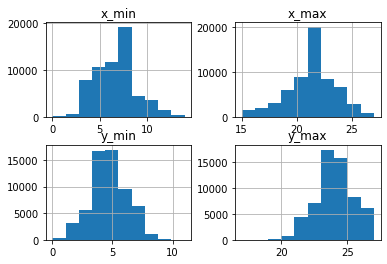

In [ ]:
### From prior example notebook
# # An utility function that returns where the digit is in the image.
# def digit_area(mnist_image):
#   # Remove the color axes
#   mnist_image = np.squeeze(mnist_image, axis=2)

#   # Extract the list of columns that contain at least 1 pixel from the digit
#   x_nonzero = np.nonzero(np.amax(mnist_image, 0))
#   x_min = np.min(x_nonzero)
#   x_max = np.max(x_nonzero)

#   # Extract the list of rows that contain at least 1 pixel from the digit
#   y_nonzero = np.nonzero(np.amax(mnist_image, 1))
#   y_min = np.min(y_nonzero)
#   y_max = np.max(y_nonzero)

#   return [x_min, x_max, y_min, y_max]

# # Calculate the area containing the digit across MNIST dataset
# digit_area_rows = []
# for image in train_images:
#   digit_area_row = digit_area(image)
#   digit_area_rows.append(digit_area_row)
# digit_area_df = pd.DataFrame(
#   digit_area_rows,
#   columns=['x_min', 'x_max', 'y_min', 'y_max']
# )
# digit_area_df.hist()

Now from the histogram, you can confirm that the digit in MNIST images are fitted nicely in an certain area at the center of the images. 

![Mnist range](http://download.tensorflow.org/models/tflite/digit_classifier/mnist_range.png)

However, when you wrote digits in your Android app, you probably did not pay attention to make sure your digit fit in the virtual area that the digits appear in MNIST dataset. The machine learning model have not seen such data before so it performed poorly, especially when you wrote a digit that was off the center of the drawing pad.

Let's add some data augmentation to the MNIST dataset to verify if our assumption is true. We will distort our MNIST dataset by adding:
* Rotation
* Width and height shift
* Shear
* Zoom

In [ ]:
### From prior example notebook
# # Define data augmentation
# datagen = keras.preprocessing.image.ImageDataGenerator(
#   rotation_range=30,
#   width_shift_range=0.25,
#   height_shift_range=0.25,
#   shear_range=0.25,
#   zoom_range=0.2
# )

# # Generate augmented data from MNIST dataset
# train_generator = datagen.flow(train_images, train_labels)
# test_generator = datagen.flow(test_images, test_labels)

In [ ]:
### I tried data augmentation, but since the number of training data points per letter is less and not equal in quantity, 
### the augmented data actually performed much worse for the EMNIST data
# Define data augmentation
datagen = keras.preprocessing.image.ImageDataGenerator(
  rotation_range=30,
  width_shift_range=0.25,
  height_shift_range=0.25,
  shear_range=0.25,
  zoom_range=0.2
)

# Generate augmented data from MNIST dataset
EMNIST_train_generator = datagen.flow(EMNIST_train_data, EMNIST_train_labels)
EMNIST_test_generator = datagen.flow(EMNIST_test_data, EMNIST_test_labels)

Let's see what our digit images look like after augmentation. You can see that we now clearly have much more variation on how the digits are placed in the images.

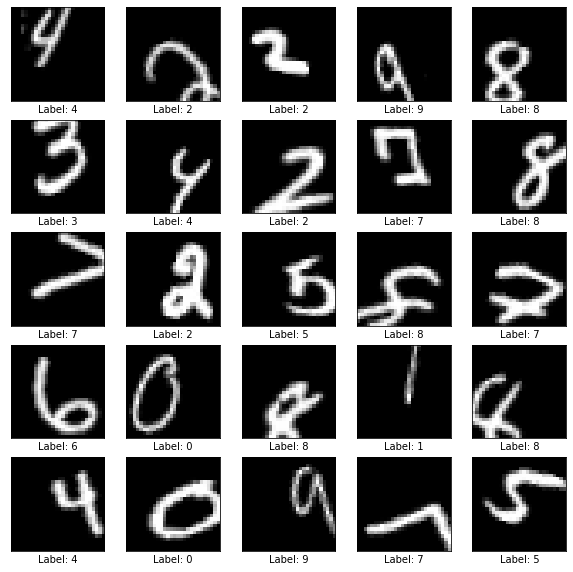

In [ ]:
### From prior example notebook
# augmented_images, augmented_labels = next(train_generator)
# plt.figure(figsize=(10,10))
# for i in range(25):
#     plt.subplot(5,5,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(np.squeeze(augmented_images[i], axis=2), cmap=plt.cm.gray)
#     plt.xlabel('Label: %d' % augmented_labels[i])
# plt.show()

In [ ]:
EMNIST_augmented_images, EMNIST_augmented_labels = next(EMNIST_train_generator)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(EMNIST_augmented_images[i], axis=2), cmap=plt.cm.gray)
    plt.xlabel('Label: %d' % EMNIST_augmented_labels[i])
plt.show()

Let's evaluate the digit classifier model that we trained earlier on this augmented test dataset and see if it makes accuracy drop.

In [ ]:
### From prior example notebook
# base_model.evaluate(test_generator)

313/313 [==============================] - 4s 14ms/step - loss: 5.6497 - accuracy: 0.3371


[5.649719715118408, 0.33709999918937683]

You can see that accuracy significantly dropped to below 40% in augmented test dataset.

# Improve accuracy with data augmentation

Now let's train our model using augmented dataset to make it perform better in deployment.

In [ ]:
### From prior example notebook
# improved_model = create_model()
# improved_model.fit(train_generator, epochs=5, validation_data=test_generator)

Epoch 1/5
1875/1875 [==============================] - 26s 14ms/step - loss: 0.9708 - accuracy: 0.6878 - val_loss: 0.4989 - val_accuracy: 0.8554
Epoch 2/5
1875/1875 [==============================] - 26s 14ms/step - loss: 0.4774 - accuracy: 0.8568 - val_loss: 0.3561 - val_accuracy: 0.8982
Epoch 3/5
1875/1875 [==============================] - 25s 13ms/step - loss: 0.3843 - accuracy: 0.8852 - val_loss: 0.2840 - val_accuracy: 0.9155
Epoch 4/5
1875/1875 [==============================] - 27s 14ms/step - loss: 0.3327 - accuracy: 0.8996 - val_loss: 0.2773 - val_accuracy: 0.9145
Epoch 5/5
1875/1875 [==============================] - 25s 13ms/step - loss: 0.3052 - accuracy: 0.9084 - val_loss: 0.2668 - val_accuracy: 0.9185


In [ ]:
improved_model = create_model()
improved_model.fit(EMNIST_train_generator, epochs=5, validation_data=EMNIST_test_generator)

Epoch 1/5
18539/18539 [==============================] - 249s 13ms/step - loss: 1.2439 - accuracy: 0.6444 - val_loss: 0.8859 - val_accuracy: 0.7380
Epoch 2/5
18539/18539 [==============================] - 241s 13ms/step - loss: 0.8876 - accuracy: 0.7340 - val_loss: 0.7813 - val_accuracy: 0.7641
Epoch 3/5
18539/18539 [==============================] - 232s 12ms/step - loss: 0.8145 - accuracy: 0.7528 - val_loss: 0.7271 - val_accuracy: 0.7777
Epoch 4/5
18539/18539 [==============================] - 233s 13ms/step - loss: 0.7783 - accuracy: 0.7626 - val_loss: 0.6986 - val_accuracy: 0.7846
Epoch 5/5
18539/18539 [==============================] - 231s 12ms/step - loss: 0.7605 - accuracy: 0.7673 - val_loss: 0.6841 - val_accuracy: 0.7891


We can see that as the models saw more distorted digit images during training, its accuracy evaluated distorted test digit images were significantly improved to about 90%.

In [ ]:
# Empty dis junk, we no need it no more, gotta save $$$ and not go premium loool
EMNIST_train_generator = []
EMNIST_train_data = []
EMNIST_train_labels = []
EMNIST_test_generator = []
EMNIST_test_data = []
EMNIST_test_labels = []

# Convert to TensorFlow Lite

Let's convert the improved model to TensorFlow Lite and redeploy to the Android app.

In [ ]:
### From prior example notebook
# # Convert Keras model to TF Lite format and quantize.
# converter = tf.lite.TFLiteConverter.from_keras_model(improved_model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# tflite_quantized_model = converter.convert()

# # Save the quantized model to file to the Downloads directory
# f = open('mnist.tflite', "wb")
# f.write(tflite_quantized_model)
# f.close()

# # Download the digit classification model
# from google.colab import files
# files.download('mnist.tflite')

In [ ]:
# Convert Keras model to TF Lite format and quantize.
converter = tf.lite.TFLiteConverter.from_keras_model(EMNIST_base_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Save the quantized model to file to the Downloads directory
f = open('emnist.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

# Download the digit classification model
from google.colab import files
files.download('mnist.tflite')

INFO:tensorflow:Assets written to: /tmp/tmp_opqif_3/assets


INFO:tensorflow:Assets written to: /tmp/tmp_opqif_3/assets


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Good job!
This is the end of *Improve model accuracy with data augmentation* in the codelab **Build a handwritten digit classifier app with TensorFlow Lite**. You can repeat [step 3](https://codelabs.developers.google.com/codelabs/digit-classifier-tflite/#2) to redeploy the improved model to your Android app and see if accuracy has been improved.